<a href="https://colab.research.google.com/github/MeldaChen/Group-4/blob/main/%E4%B8%BB%E7%A8%8B%E5%BC%8F%E9%83%A8%E7%BD%B2_%E5%87%B1%E7%90%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install line-bot-sdk flask flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.3 MB/s 


In [ ]:
# 引用Web Server套件
from flask import Flask, request, abort, jsonify

# 載入json處理套件
import json

# 外部連結自動生成套件
from flask_ngrok import run_with_ngrok

# 從linebot 套件包裡引用 LineBotApi 與 WebhookHandler 類別
from linebot import (
    LineBotApi, WebhookHandler
)

# 引用無效簽章錯誤
from linebot.exceptions import (
    InvalidSignatureError
)

In [ ]:
'''
建置主程序

建置handler與 line_bot_api
'''

# 設定Server啟用細節
app = Flask(__name__,static_url_path = "/material" , static_folder = "./material/")
run_with_ngrok(app)

# 生成實體物件
line_bot_api = LineBotApi("y5vKOviRTFsN8VP5y4EVl3lpSGOjqmJjOvAnH89ThLyATG4I4kC4dnCZZ0sa8MfZgUyvQCFT/oKLpAVC6ZXjUzDzyl1rBGnuGY4aMo3ewbAV2nIl0kmMY/ae0QsbDQHh08QEk9M6sfZ9wKhcWOZP6QdB04t89/1O/w1cDnyilFU=")
handler = WebhookHandler("8f67c035674deaa1a6c3e6daf96146a3")

In [ ]:
'''
建置主程序的API入口
  接受Line傳過來的消息
  並取出消息內容
  將消息內容存在google drive的檔案內
  並請handler 進行消息驗證與轉發
'''

# 啟動server對外接口，使Line能丟消息進來
@app.route("/", methods=['POST'])
def callback():
    # get X-Line-Signature header value
    signature = request.headers['X-Line-Signature']

    # get request body as text
    body = request.get_data(as_text=True)
    print(body)

    # 記錄用戶log
    f = open("/content/drive/MyDrive/ai-event.log", "a")
    f.write(body)
    f.close()

    # handle webhook body
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)

    return 'OK'

In [ ]:
import cv2
import numpy as np
import IPython.display as dp
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt 
import math
'''

若收到圖片消息時，

先回覆用戶文字消息，並從Line上將照片拿回。

'''
import math
import cv2 as cv
import numpy as np
from linebot.models import(
    MessageEvent,ImageMessage, TextSendMessage
)

def image_processing_1(image_name,image_path):
    #讀取照片原圖
    im = cv.imread(image_path)

@handler.add(MessageEvent, message=ImageMessage)
def handle_message(event):
    message_content = line_bot_api.get_message_content(event.message.id)
    with open('im.jpg', 'wb') as fd:
        for chunk in message_content.iter_content():
            fd.write(chunk)
    m1 = cv2.imread('im.jpg', 1)

    copy = m1.copy()

    m1_g = cv2.cvtColor(m1, cv2.COLOR_BGR2GRAY) # 手寫字轉灰階

    ret, m1_new = cv2.threshold(m1_g, 127, 255, cv2.THRESH_BINARY) # 手寫字轉黑底白字 

    erode = cv2.erode(copy, np.ones((30, 30))) #抓字

    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY) #轉灰階

    blur = cv2.GaussianBlur(gray,(5,5),0)   #模糊化


    canny = cv2.Canny(blur, 70, 210)

    th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

    morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
    p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(p)== 1:
        x, y, w, h = cv2.boundingRect(p[0]) 
        cv2.rectangle(m1_new, (x,y), (x+w, y+h), (255, 255, 255), 2) #框線改白色
        capture_img = m1_new[y : y + h, x : x + w] #框起來的地方
        
        resize_capture = cv2.resize(capture_img, (50, 50), interpolation=cv2.INTER_AREA)

        cv2.imwrite("resize_capture.png", resize_capture) #存成 50*50 的手寫字
        resize_capture = cv2.imread("resize_capture.png", 1)
        # 手寫辨識
        y_dict = {0:"者",1:"我",2:"國",3:"來",4:"面",5:"過",6:"為",7:"大",8:"成",9:"民"}
        m = cv2.ml.KNearest_load('tch_knn.xml')   # 載入模型
        img = cv2.imread("resize_capture.png", 0)
        ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
        img = cv2.resize(img,(50, 50))
        img = img.astype(np.float32)    # 轉換格式
        img = img.reshape(-1)          # 打散成一維陣列資料，轉換成辨識使用的格式
        img = img.reshape(1,-1)
        img = img/255

        img_pre = m.predict(img)          # 進行辨識

        text = y_dict[int(img_pre[1][0][0])]        # 取得辨識結果


        compare_word = np.full((50, 50, 3), (255, 255, 255), np.uint8) 
        compare_word = Image.fromarray(compare_word)
        ImageDraw.Draw(compare_word).text((0,0),
                    (text), #要換成練習的字
                    (0, 0, 0),
                    ImageFont.truetype("ThePeakFontBeta_V0_101.ttf", 50)  #要上傳字體
        )
        compare_word = np.array(compare_word)
        

        

        cv2.imwrite("compare.png", compare_word) # 生成的字存成 compare.png，要再取一次輪廓

        compare_img = cv2.imread('compare.png', 1) 

        copy = compare_img.copy()

        # erode = cv2.erode(copy, np.ones((30, 30)))  

        # blur = cv2.GaussianBlur(erode,(5,5),0) 

        canny = cv2.Canny(copy, 70, 210)

        th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

        morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
        p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(p[0]) 
        cv2.rectangle(compare_img, (x,y), (x+w, y+h), (255, 255, 255), 2)  #框線改白色
        cv2.imwrite("compare2.png", compare_img[y : y + h, x : x + w]) #要再resize

        compare2_img = cv2.imread('compare2.png', 1)

        resize_compare = cv2.resize(compare2_img, (50, 50), interpolation=cv2.INTER_AREA)
        cv2.imwrite("resize_compare.png", resize_compare) #存成 50*50 的比對字
      
        # 用resize_capture.png 跟resize_compare.png 比對分數

        # 最簡單的以灰度直方圖作為相似比較的實現 
        def classify_gray_hist(image1,image2,size = (256,256)): 
        # 先計算直方圖 
        # 幾個引數必須用方括號括起來 
        # 這裡直接用灰度圖計算直方圖，所以是使用第一個通道， 
        # 也可以進行通道分離後，得到多個通道的直方圖 
        # bins 取為16 
          image1 = cv2.resize(image1,size) 
          image2 = cv2.resize(image2,size) 
          hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
          hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 

        # 計算直方圖的重合度 
          degree = 0 
          for i in range(len(hist1)): 
            if hist1[i] != hist2[i]: 
              degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
            else: 
              degree = degree + 1 
          degree = degree/len(hist1) 
          return degree 
    
    # 計算單通道的直方圖的相似值 
        def calculate(image1,image2): 
          hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
          hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 
          # 計算直方圖的重合度 
          degree = 0 
          for i in range(len(hist1)): 
            if hist1[i] != hist2[i]: 
              degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
            else: 
             degree = degree + 1 
          degree = degree/len(hist1) 
          return degree 
    
        # 通過得到每個通道的直方圖來計算相似度 
        def classify_hist_with_split(image1,image2,size = (256,256)): 
        # 將影象resize後，分離為三個通道，再計算每個通道的相似值 
          image1 = cv2.resize(image1,size) 
          image2 = cv2.resize(image2,size) 
          sub_image1 = cv2.split(image1) 
          sub_image2 = cv2.split(image2) 
          sub_data = 0 
          for im1,im2 in zip(sub_image1,sub_image2): 
            sub_data += calculate(im1,im2) 
          sub_data = sub_data/3 
          return sub_data 
    
    
        if __name__ == '__main__': 
          img1 = cv2.imread('resize_compare.png') #這一段東西需要回傳給使用者,修改中
          cv2_imshow(img1) 
          img2 = cv2.imread('resize_capture.png') 
          cv2_imshow(img2) 
          degree1 = classify_gray_hist(img1,img2) 
          reply = (str(np.round(degree1 * 100)))
          line_bot_api.reply_message(event.reply_token, TextSendMessage(text='您的分數是'+reply+'分'))
          message_content = line_bot_api.get_message_content(event.message.id)
          with open('im.jpg', 'wb') as fd:
            for chunk in message_content.iter_content():
              fd.write(chunk)


    else:
      line_bot_api.reply_message(event.reply_token, TextSendMessage(text="請靠近文字再拍攝一次"))
      message_content = line_bot_api.get_message_content(event.message.id)
      with open('im.jpg', 'wb') as fd:
        for chunk in message_content.iter_content():
          fd.write(chunk)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://9af6-35-192-3-57.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:21:05] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[]}
{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224727435464","contentProvider":{"type":"line"}},"webhookEventId":"01GK8QZX2MZ54RYE78XDGRY157","deliveryContext":{"isRedelivery":false},"timestamp":1669962134110,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"20e53c5c5a5b4f5fa8178387c9f8e5b1","mode":"active"}]}


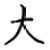

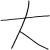

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:22:18] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224728365460","contentProvider":{"type":"line"}},"webhookEventId":"01GK8R09030V9W937N901STAXC","deliveryContext":{"isRedelivery":false},"timestamp":1669962146711,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"3062a81c043a4af9ad9ad1fb7ccdbb6c","mode":"active"}]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:22:29] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224729028019","contentProvider":{"type":"line"}},"webhookEventId":"01GK8R0HQPXVCGDPWT9SETXSEY","deliveryContext":{"isRedelivery":false},"timestamp":1669962155656,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"fff5017755914ffd8c43f125a214e5ef","mode":"active"}]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:22:39] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224729913237","contentProvider":{"type":"line"}},"webhookEventId":"01GK8R0XW2MYTZWMNZZH9PM7J2","deliveryContext":{"isRedelivery":false},"timestamp":1669962167689,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"5306b9aa4248486bb38f4718dab8b20b","mode":"active"}]}


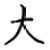

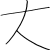

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:22:51] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:35:12] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224784790210","contentProvider":{"type":"line"}},"webhookEventId":"01GK8RQYXST3CE2JEESP6RRJWX","deliveryContext":{"isRedelivery":false},"timestamp":1669962922808,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"684fc1f1ad6a4820b90dbbeeab19b644","mode":"active"}]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:35:27] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224785629580","contentProvider":{"type":"line"}},"webhookEventId":"01GK8RRASRCBMTM6T59N1TY28K","deliveryContext":{"isRedelivery":false},"timestamp":1669962934591,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"149274364bae46c39c0341a2849f6277","mode":"active"}]}


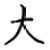

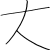

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 06:35:38] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 07:06:14] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224921931739","contentProvider":{"type":"line"}},"webhookEventId":"01GK8TGMXA8BHGC5NG02HMN1MX","deliveryContext":{"isRedelivery":false},"timestamp":1669964780097,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"955a913daf984ddfa3f9f53f2dbade3a","mode":"active"}]}


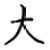

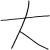

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 07:06:24] "POST / HTTP/1.1" 200 -


{"destination":"U824ef4cf00ee1105ffe2e3d2e4406673","events":[{"type":"message","message":{"type":"image","id":"17224922844182","contentProvider":{"type":"line"}},"webhookEventId":"01GK8TH0F24ESYXWQ3KDNPQ3QN","deliveryContext":{"isRedelivery":false},"timestamp":1669964792016,"source":{"type":"user","userId":"Uc730ee660b50e0fe512c9dd1b5d5b501"},"replyToken":"9a71b92d2866475998f070bcb095ac60","mode":"active"}]}


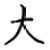

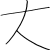

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 07:06:35] "POST / HTTP/1.1" 200 -


In [ ]:
app.run()